In [14]:
import tarfile
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.optimize import curve_fit
import matplotlib.ticker as mticker
# Funzione di fit (es. lineare)
def linear_fit(x, a, b):
    return a * x + b

# Liste per i dati del fit
y_final_values = []
divisor_values = []

# List of archive paths
archive_paths = [
    "/home/dcarbone/catene/test/compressed_archive_N_500.tar.gz"
]

# Directory principale per salvare i PDF
main_output_dir = "./plots"

for archive_path in archive_paths:
    # Estrai il valore di N dal percorso dell'archivio
    match = re.search(r'compressed_archive_N_(\d+)', archive_path)
    if match:
        N = match.group(1)
        output_dir = os.path.join(main_output_dir, f"N_{N}")  # Crea una cartella basata su N
    else:
        N = "Unknown"
        output_dir = os.path.join(main_output_dir, "Unknown_N")  # Cartella generica se N non trovato

    os.makedirs(output_dir, exist_ok=True)  # Crea la cartella per questo valore di N

    # Liste per i dati dei plot finali
    all_df_data = []
    all_integral_df_data = []

    with tarfile.open(archive_path, 'r:gz') as archive:
        # List all .dat files in the archive
        files = [member.name for member in archive.getmembers() if member.name.endswith('.dat')]
        print(files)        
        for file_name in files:
            with archive.extractfile(file_name) as file:
                # Skip "Tr_1.dat"
                
                if "Tr_1.dat" in file_name:
                    continue

                # Extract Tr value
                match = re.search(r'Tr_([0-9]+(?:\.[0-9]+)?)', file_name)
                if match:
                    try:
                        Tr = float(match.group(1))  # Converte Tr in float
                    except ValueError:
                        print(f"Error: Couldn't convert Tr value '{match.group(1)}' to float in filename {file_name}, skipping...")
                        continue
                else:
                    print(f"Warning: Couldn't extract Tr from filename {file_name}, skipping...")
                    continue

                # Avoid division by zero
                if Tr <= 1:
                    print(f"Warning: Skipping file {file_name} due to Tr={Tr} <= 1")
                    continue

                # Load the data
                data = np.loadtxt(file)
                print(file_name)
                print("ciao")
                if data.shape[1] != 2:
                    print(f"Warning: {file_name} doesn't have exactly two columns, skipping...")
                    continue

                # Normalize data
                x = data[:, 0]
                y = data[:, 1]
                divisor = Tr - 1
                
                x_normalized = x / divisor*float(N)
                y_normalized = y / divisor*float(N)
                print(np.mean(x_normalized[-1:-20000:-1]))
                y_final_values.append(np.mean(y[-100:]))
                divisor_values.append(divisor/float(N))


                # Create DataFrames
                df = pd.DataFrame(x_normalized, columns=["x_normalized"])
                
                integral_df = pd.DataFrame(y_normalized, columns=["y_normalized"])

                # Salvare i dati per i plot finali
                all_df_data.append((file_name, df))
                all_integral_df_data.append((file_name, integral_df))

                # Plot df
                plt.figure(figsize=(8, 5))
                plt.plot(df, label="Normalized x")
                plt.xlabel("Index")
                plt.ylabel("Normalized x")
                plt.title(f"{file_name} - Normalized x")
                plt.legend()
                plt.grid()
                pdf_path_df = os.path.join(output_dir, f"N_{N}_Tr_{Tr}_df.pdf")  # Nominare il file come richiesto
                plt.savefig(pdf_path_df)
                plt.close()

                # Plot integral_df
                plt.figure(figsize=(8, 5))
                plt.plot(integral_df, label="Normalized y")
                plt.xlabel("Index")
                plt.ylabel("Normalized y")
                plt.title(f"{file_name} - Normalized y")
                plt.legend()
                plt.grid()
                pdf_path_integral = os.path.join(output_dir, f"N_{N}_Tr_{Tr}_integral_df.pdf")  # Nominare il file come richiesto
                plt.savefig(pdf_path_integral)
                plt.close()

                print(f"Saved plots for {file_name} to {pdf_path_df} and {pdf_path_integral}")
                   # Fit dei dati raccolti
    divisor_values = np.array(divisor_values)
    y_final_values = np.array(y_final_values)

    try:
    # Fit lineare
        popt, pcov = curve_fit(linear_fit, divisor_values, y_final_values)
        a, b = popt
        perr = np.sqrt(np.diag(pcov))  # Incertezze sui parametri

        print(f"Fit parameters: a={a} ± {perr[0]}, b={b} ± {perr[1]}")

        # Genera i dati del fit per il plot
        x_fit = np.linspace(min(divisor_values), max(divisor_values), 500)
        y_fit = linear_fit(x_fit, a, b)

        # Plot dei risultati del fit
        plt.figure(figsize=(8, 5))
        plt.errorbar(divisor_values, y_final_values, fmt='o', label="Data", color="blue")
        plt.plot(x_fit, y_fit, label=f"Fit: y = ({a:.2e} ± {perr[0]:.2e})x + ({b:.2e} ± {perr[1]:.2e})", color="red")

        # Configurazione asse y in notazione scientifica
        plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

        # Etichette e titolo
        plt.xlabel("DT/DX")
        plt.ylabel("Flux")
        plt.title("Fit of y[-1] vs Divisor with Uncertainties")
        plt.legend()
        plt.grid()

        # Salva il plot
        fit_plot_path = os.path.join(output_dir, f"N_{N}_fit_df.pdf")
        plt.savefig(fit_plot_path)
        plt.close()

        print(f"Saved fit plot to {fit_plot_path}")
    except Exception as e:
        print(f"Error during fitting: {e}")


    # Creazione dei plot finali
    # Plot con tutte le df
    plt.figure(figsize=(10, 6))
    for file_name, df in all_df_data:
        plt.plot(df, label=file_name)
    plt.xlabel("Index")
    plt.ylabel("Normalized x")
    plt.title(f"All Normalized x (df) - N={N}")
    plt.legend(fontsize=8)
    plt.grid()
    final_df_path = os.path.join(output_dir, f"all_N_{N}_df.pdf")
    plt.savefig(final_df_path)
    plt.close()
    print(f"Saved combined plot of all df to {final_df_path}")

    # Plot con tutte le integral_df
    plt.figure(figsize=(10, 6))
    for file_name, integral_df in all_integral_df_data:
        plt.plot(integral_df, label=file_name)
    plt.xlabel("Index")
    plt.ylabel("Normalized y")
    plt.title(f"All Normalized y (integral_df) - N={N}")
    plt.legend(fontsize=8)
    plt.grid()
    final_integral_df_path = os.path.join(output_dir, f"all_N_{N}_integral_df.pdf")
    plt.savefig(final_integral_df_path)
    plt.close()
    print(f"Saved combined plot of all integral_df to {final_integral_df_path}")

 

['test/ttcf_mil_N_500_Tr_11.dat', 'test/ttcf_mil_N_500_Tr_13.5.dat', 'test/ttcf_mil_N_500_Tr_16.dat', 'test/ttcf_mil_N_500_Tr_18.5.dat', 'test/ttcf_mil_N_500_Tr_6.dat', 'test/ttcf_mil_N_500_Tr_8.5.dat']
test/ttcf_mil_N_500_Tr_11.dat
ciao
0.0001823046961135555
Saved plots for test/ttcf_mil_N_500_Tr_11.dat to ./plots/N_500/N_500_Tr_11.0_df.pdf and ./plots/N_500/N_500_Tr_11.0_integral_df.pdf
test/ttcf_mil_N_500_Tr_13.5.dat
ciao
0.0003980460131530174
Saved plots for test/ttcf_mil_N_500_Tr_13.5.dat to ./plots/N_500/N_500_Tr_13.5_df.pdf and ./plots/N_500/N_500_Tr_13.5_integral_df.pdf
test/ttcf_mil_N_500_Tr_16.dat
ciao
0.0007771600719685982
Saved plots for test/ttcf_mil_N_500_Tr_16.dat to ./plots/N_500/N_500_Tr_16.0_df.pdf and ./plots/N_500/N_500_Tr_16.0_integral_df.pdf
test/ttcf_mil_N_500_Tr_18.5.dat
ciao
0.00031108060781667637
Saved plots for test/ttcf_mil_N_500_Tr_18.5.dat to ./plots/N_500/N_500_Tr_18.5_df.pdf and ./plots/N_500/N_500_Tr_18.5_integral_df.pdf
test/ttcf_mil_N_500_Tr_6.dat
cia

4001220
(10000, 166)


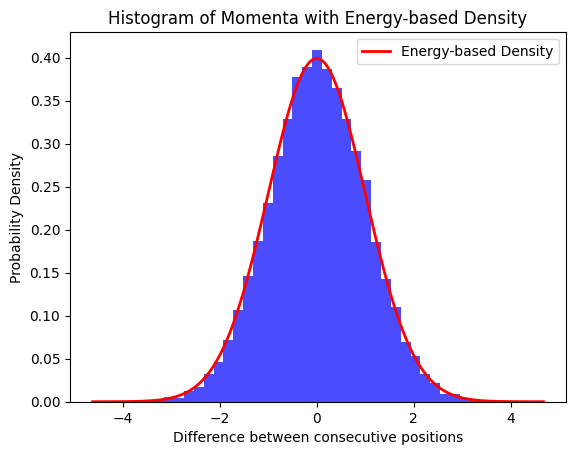

In [32]:
import numpy as np
import os
import random

def read_conditions(filename, num_condizioni, neq):
    # Verifica se il file esiste
    if not os.path.exists(filename):
        print("Errore nell'apertura del file per lettura!")
        return None
    
    # Dimensione di una condizione in byte
    dimensione_condizione = neq * np.dtype('float64').itemsize
    
    # Ottieni la dimensione totale del file
    file_size = os.path.getsize(filename)
    
    # Calcola il numero di condizioni nel file
    numero_condizioni_tot = file_size // dimensione_condizione

    print(numero_condizioni_tot)
    
    if num_condizioni > numero_condizioni_tot:
        print("Errore: il numero di condizioni richiesto eccede il numero di condizioni nel file.")
        return None

    # Inizializza il vettore per le condizioni
    condizioni = np.empty(num_condizioni * neq, dtype='float64')

    # Apri il file in modalità binaria
    with open(filename, 'rb') as inFile:
        for i in range(num_condizioni):
            # Seleziona un indice casuale
            indice_casuale = random.randint(0, numero_condizioni_tot - 1)
            
            # Calcola l'offset dell'indice
            offset = indice_casuale * dimensione_condizione
            
            # Posizionarsi nel file all'offset desiderato
            inFile.seek(offset)
            
            # Leggi la condizione e mettila nel vettore
            condition_data = np.fromfile(inFile, dtype='float64', count=neq)
            if condition_data.size != neq:
                print("Errore durante la lettura del file!")
                return None
            
            condizioni[i * neq : (i + 1) * neq] = condition_data

    return condizioni


filename = "condizioni_80.bin"
num_condizioni = 10000  # Numero di condizioni da leggere
N=80
dim=1
neq= (N+2)*2*dim + 2

condizioni = read_conditions(filename, num_condizioni, neq)
if condizioni is not None:
    cond_t=condizioni.reshape(num_condizioni,neq)[:,:neq]
print(cond_t.shape)


import numpy as np
import matplotlib.pyplot as plt

# Supponendo che `cond_t` sia già definito
# Estrai solo le colonne di `x` per ciascuna catena
x_values = cond_t[:, ::2]  # Prende solo le colonne alternate, che sono i valori `x`
p_values=np.concatenate(cond_t[:, 3:-2:2])
xival=np.concatenate(cond_t[:, -2:])
# Calcola le differenze tra valori successivi di `x` per ciascuna catena (prima dimensione)
diff_x_all = [np.diff(x_chain) for x_chain in x_values]

# Unisci tutte le differenze in un singolo array per l'istogramma
diff_x_all = np.concatenate(diff_x_all)

# Crea l'istogramma delle differenze
plt.hist(xival, bins=40, density=True, alpha=0.7, color='blue')

def energy(x, a, b):
    return x**2/2#(x-1)**2/2 + a * (x-1)**3/3 + b * (x-1)**4/4

def density(x, a, b, beta):
    return np.exp(-beta * energy(x, a, b))

# Generate x values for plotting the density
x_vals = np.linspace(min(p_values), max(p_values), 500)
density_vals = density(x_vals, 0, 1, 1)
density_vals /= np.trapz(density_vals, x_vals)  # Normalize the density

# Step 5: Plot the density function
plt.plot(x_vals, density_vals, color='red', linewidth=2, label='Energy-based Density')

# Add labels and legend
plt.xlabel('Difference between consecutive positions')
plt.ylabel('Probability Density')
plt.title('Histogram of Momenta with Energy-based Density')
plt.legend()
plt.show()

In [5]:
cond_t[0,62:]

array([31.,  0.])

<>:246: SyntaxWarning: invalid escape sequence '\D'
<>:246: SyntaxWarning: invalid escape sequence '\D'
/var/tmp/ipykernel_132429/3868396954.py:246: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Values (Normalized by $\Delta T$)")


[1.00000000e+00 1.83055369e+00 3.35092683e+00 6.13405148e+00
 1.12287106e+01 2.05547577e+01 3.76265876e+01 6.88774889e+01
 1.26083942e+02 2.30803425e+02 4.22498063e+02 7.73405389e+02
 1.41576009e+03 2.59162487e+03 4.74410847e+03 8.68434529e+03
 1.58971604e+04 2.91006056e+04 5.32702211e+04 9.75140000e+04]


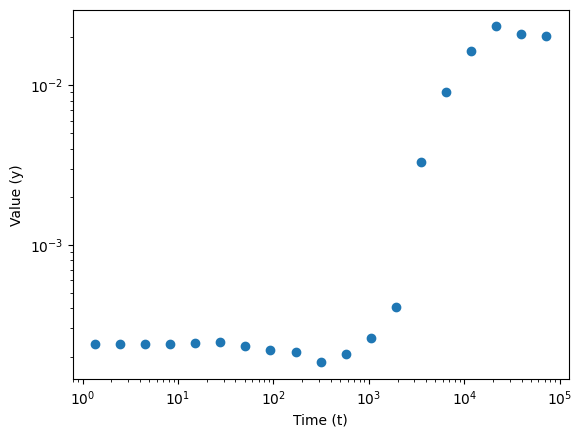

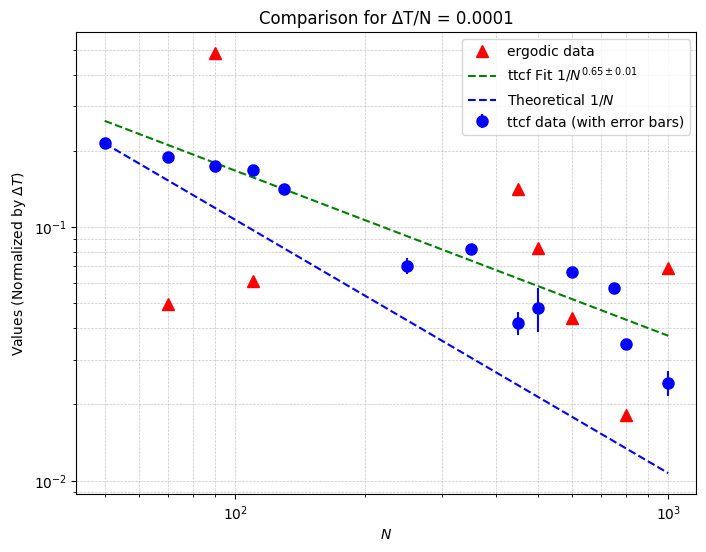

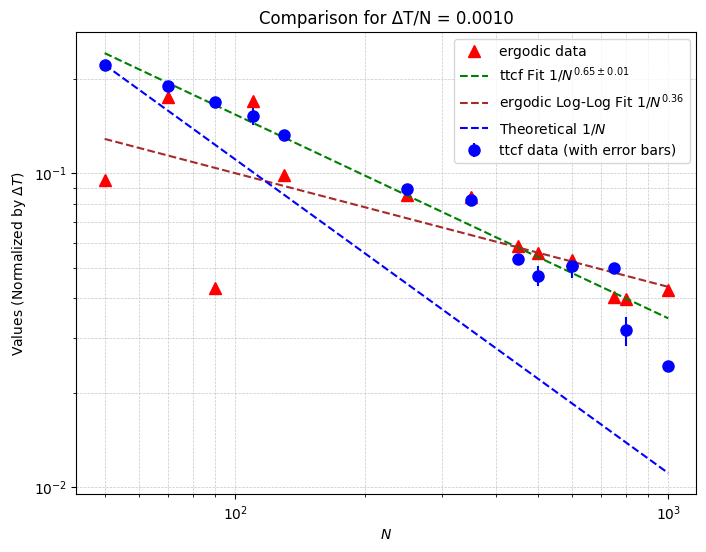

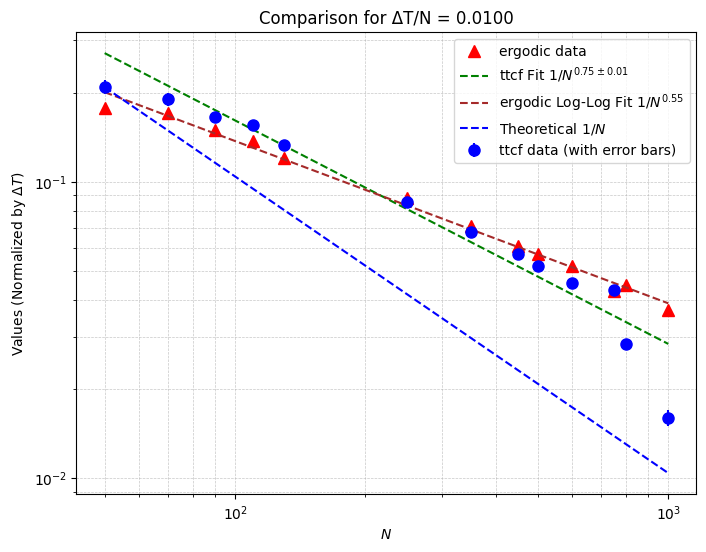

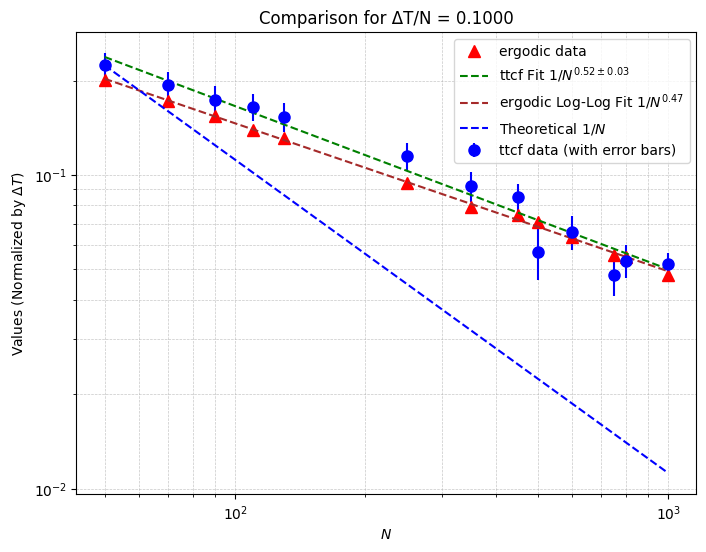

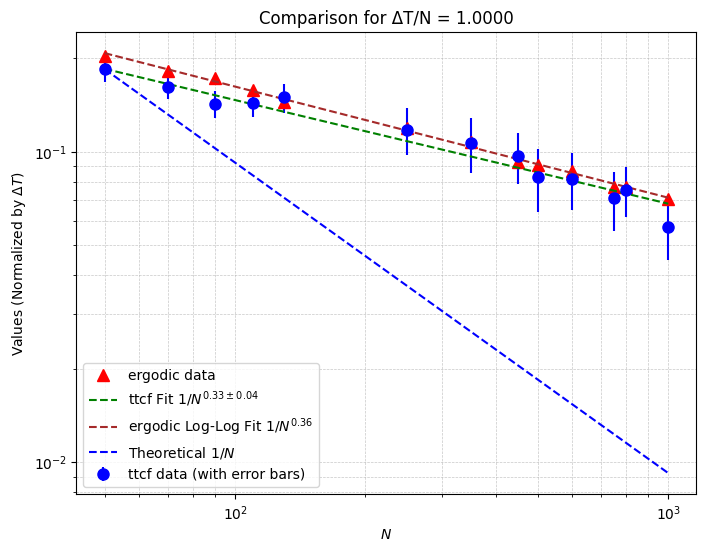

In [49]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

folder_path_tcf = "/home/dcarbone/catene/dt_fix/"

# 1. Process ttcf_mil_N_<number>_Tr_<deltaT>.dat files
file_list_tcf = [f for f in os.listdir(folder_path_tcf) if f.startswith("ttcf_mil_N_") and f.endswith(".dat")]
file_list_tcf.sort(key=lambda x: int(x.split("_")[3]))  # Sort by N

# Prepare data for the first set of files
N_values = []
last_col2_means = []
last_col2_semi_dispersion = []  # To store semidispersions
deltaT_N_ratios = []  # Store deltaT / N values for coloring
store=[]
t=np.linspace(0,100000,100000)
for file_name in file_list_tcf:
    if "N_30" not in file_name:# and "N_800" not in file_name and "N_1000" not in file_name:
        file_path = os.path.join(folder_path_tcf, file_name)
        data = np.loadtxt(file_path)
        
        N = int(file_name.split("_")[3])  # Extract N
        deltaT = np.round(float(file_name.split("_")[-1].split(".d")[0]) - 1, 4)  # Extract deltaT (last number before .dat) and subtract 1
        
        
        deltaT_N_ratio = round(deltaT / N, 4)
        if deltaT_N_ratio<10:
           

            # Define logarithmic bin edges
            
            
            deltaT_N_ratios.append(deltaT_N_ratio)
            N_values.append(N)
    #         from scipy.signal import savgol_filter

    #             # Apply Savitzky-Golay filter
    #         window_size = 1000  # Must be odd
            
    #         denoised = data[2000+int(N/500)*4000+int(N/1000)*8000::500, 1]/deltaT

            
    #         gradient = np.diff(denoised)
            
    # # Find indices where the gradient changes from positive to negative
    #         indices = np.where((gradient[:-1] > 0) & (gradient[1:] < 0))[0]

    #         if len(indices) > 1:

    #             first_maximum_index = indices[0] + 1  # Offset due to np.diff
    #             second=indices[1] + 1
    #             mean_value=np.mean(denoised[first_maximum_index:second])
    #             if N>500:
    #                 mean_value=np.mean(normalized_data[30000:100000])
            
    #             #store.append()#denoised[first_maximum_index]
                
                
                
            # else:
            #     print("No maximum found")
            normalized_data = data[:, 1] / deltaT
            # mean_value = np.mean(normalized_data[80000:100000])  # Mean of last 100 points
            # semi_dispersion=np.std(normalized_data[80000:100000])
            # Semidispersion (set to 0 for now)
            max_pos=np.argmax(data[:100000, 0]/deltaT)

            if deltaT_N_ratio==0.001 and N==500:
                #print(N)
            
                

                # Plot the results
                
                #plt.plot( data[:100000, 0], label="Noisy Data")
                #from skchange.change_detectors.moving_window import MovingWindow
                

                
                
                # detector = MovingWindow(bandwidth=int(np.argmin(data[0:100000, 0])),min_detection_interval=int(np.argmin(data[0:100000, 0])/5))
                
                # df = pd.DataFrame(data[0:100000, 0], columns=["values"])
                size_data=len(data[:,0])
                t = np.linspace(1, size_data-max_pos//2, size_data-max_pos//2)
                y = np.abs(data[max_pos//2:, 1])  

                # Logarithmic binning
                base=2
                bins = np.logspace(np.emath.logn(base,min(t)), np.emath.logn(base,max(t)), num=20, base=base)
                bin_centers = np.sqrt(bins[:-1] * bins[1:])
                binned_y = [np.mean(y[(t >= bins[i]) & (t < bins[i+1])]) for i in range(len(bins) - 1)]
                print(bins)
                
                # Plot
                #plt.loglog(t, y, alpha=0.3, linestyle=None, label="Raw data")
                plt.loglog(bin_centers, binned_y, marker='o', linestyle='None', label="Logarithmic binning")
                plt.xlabel("Time (t)")
                plt.ylabel("Value (y)")
                log_mid = np.log10(max(t)) / 2 + np.log10(min(t)) / 2
                mid = 10**log_mid  # Converte di nuovo in valore lineare

                # Crea un intervallo di tempo da metà in scala logaritmica fino a max(t)
                t_comparative = np.logspace(np.log10(mid), np.log10(max(t)), 1000)
                y_comparative = 10000 / (t_comparative)

# Traccia la linea comparativa
                #plt.loglog(t_comparative, y_comparative, label="Comparative line (1/(0.01 * t))", color="blue", linestyle='-', linewidth=2)

                #plt.legend()
                #plt.show()
                
                # predicted_change_points = detector.fit_predict(df)
                # print(predicted_change_points)
                # ind=predicted_change_points.values[-1][0]
                # print(ind)
                #plt.plot(data[0:100000, 1], label=str(N)+"_"+str(deltaT_N_ratio) )
                # plt.axvline(x=ind,color="red")
                #plt.legend()
                #print(max_pos)
                
                
                # min_pos=int(np.argmin(data[0:100000, 0]/deltaT))
            max_pos=np.argmax(data[:100000, 0]/deltaT)
            mean_value = np.mean(data[0:100000, 1][4*max_pos:6*max_pos])/deltaT

            semi_dispersion = np.std(data[0:100000, 1][4*max_pos:6*max_pos])/deltaT

            last_col2_means.append(mean_value)
            
            last_col2_semi_dispersion.append(semi_dispersion)
plt.show()
N_values = np.array(N_values)
last_col2_means = np.array(last_col2_means)
last_col2_semi_dispersion = np.array(last_col2_semi_dispersion)
deltaT_N_ratios = np.array(deltaT_N_ratios)

# Process ergodic data
folder_path_erg = "/home/dcarbone/catene/ergodic_dtfix/"

# List and process files
file_list_erg = [f for f in os.listdir(folder_path_erg) if f.startswith("ergodic_N_") and f.endswith(".dat")]
file_list_erg.sort(key=lambda x: int(x.split("_")[2]))  # Sort by N

# Initialize lists for ergodic data
ergodic_N_values = []
ergodic_means = []
ratios = []

for file_name in file_list_erg:
    if "N_30" not in file_name:  # Apply necessary filters
        file_path = os.path.join(folder_path_erg, file_name)
        with open(file_path, 'r') as f:
            line = f.readline().strip()  # Read the first line
            ergodic_mean = float(line.split(":")[1].strip())  # Extract the numeric value after "Ergodic mean:"
        
        N = int(file_name.split("_")[2])  # Extract N
        deltaT = float(file_name.split("_")[-1].split(".d")[0]) - 1  # Extract deltaT
        ratio = round(deltaT / N, 4)  # Compute and round ratio
        
        ergodic_N_values.append(N)
        ergodic_means.append(ergodic_mean / deltaT)  # Normalize by deltaT
        ratios.append(ratio)

# Convert to numpy arrays
ergodic_N_values = np.array(ergodic_N_values)
ergodic_means = np.array(ergodic_means)
ratios = np.array(ratios)


# Plot for each unique ratio
# Plot for each unique ratio
# Plot for each unique ratio
def power_law(N, A, alpha):
    return A * N ** (-alpha)

for ratio in np.unique(deltaT_N_ratios):
    plt.figure(figsize=(8, 6))
    
    # Filter data for the current ratio
    ttc_mask = (deltaT_N_ratios == ratio)
    erg_mask = (ratios == ratio)
    
    # Plot ttcf data (blue circles with error bars)
    plt.errorbar(
        N_values[ttc_mask],
        last_col2_means[ttc_mask],
        yerr=last_col2_semi_dispersion[ttc_mask],
        fmt='o',
        color='blue',
        markersize=8,
        label="ttcf data (with error bars)"
    )
    
    # Plot ergodic data (red triangles)
    plt.loglog(ergodic_N_values[erg_mask], ergodic_means[erg_mask], '^', color='red', markersize=8, label="ergodic data")
    
    # Perform the fit using error bars
    popt_ttc, pcov_ttc = curve_fit(
        power_law,
        N_values[ttc_mask],
        last_col2_means[ttc_mask],
        sigma=last_col2_semi_dispersion[ttc_mask],
        absolute_sigma=True
    )
    
    A_ttc, alpha_ttc = popt_ttc  # Extract coefficients
    A_ttc_err, alpha_ttc_err = np.sqrt(np.diag(pcov_ttc))  # Extract uncertainties
    
    # Generate fit line
    fit_line_ttc = power_law(N_values[ttc_mask], *popt_ttc)
    
    # Plot the log-log fit line for ttcf data
    plt.loglog(N_values[ttc_mask], fit_line_ttc, '--', label=f"ttcf Fit $1/N^{{{alpha_ttc:.2f}\\pm {alpha_ttc_err:.2f}}} $", color="green")
    
    plt.xlabel("N values")
    plt.ylabel("Last Column Means")
    plt.title(f"Fit for Ratio {ratio}")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    
    if np.sum(ergodic_means[erg_mask] < 0) == 0:
        # Fit the data in log-log space for ergodic data
        log_N_erg = np.log(ergodic_N_values[erg_mask])
        log_ergodic_means = np.log(ergodic_means[erg_mask])
        popt_erg_log = np.polyfit(log_N_erg, log_ergodic_means, 1)  # Linear fit in log-log space
        alpha_log_erg = -popt_erg_log[0]  # Slope is -alpha
        line_fit_erg = np.exp(popt_erg_log[1]) * (ergodic_N_values[erg_mask] ** popt_erg_log[0])  # Fit in original scale

        # Plot the log-log fit line for ergodic data
        plt.loglog(ergodic_N_values[erg_mask], line_fit_erg, '--', label=f"ergodic Log-Log Fit $1/N^{{{alpha_log_erg:.2f}}}$", color="brown")
    
    # Add the reference line for 1/N
    ref_line_1_over_N = last_col2_means[ttc_mask][0] * (1 / N_values[ttc_mask]) / (1 / N_values[ttc_mask][0])  # Scaled 1/N
    
    # Add the 1/N line to the plot
    plt.loglog(N_values[ttc_mask], ref_line_1_over_N, '--', label=r"Theoretical $1/N$", color="blue")
    
    # Customize plot
    plt.title(f"Comparison for ΔT/N = {ratio:.4f}")
    plt.xlabel(r"$N$")
    plt.ylabel("Values (Normalized by $\Delta T$)")
    plt.legend()
    plt.grid(which="both", linestyle="--", alpha=0.7)
    plt.show()




[2.142203213422527, 4.104917206005806, 8.465179875215668, 18.671320183140992, 42.01033897116983, 90.06820205407037, 179.34154365525174, 302.57597325826345, 353.47079996354444, 190.99904194946402, 23.497191925522962, 0.18184726103432752, -0.0004115085635066312, -0.0003021499989881841]


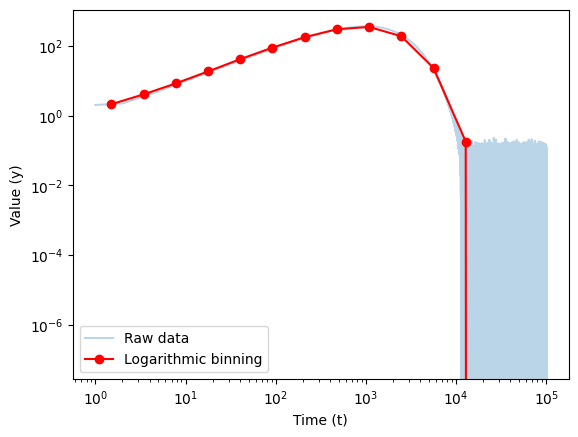

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
t = np.linspace(1, 100000, 100000)
y = (t*np.exp(-t/1000)+t**-1.5 + np.random.normal(0, 0.05, len(t)))  # Add some noise

# Logarithmic binning
bins = np.logspace(np.log10(min(t)), np.log10(max(t)), num=15)
bin_centers = np.sqrt(bins[:-1] * bins[1:])
binned_y = [np.mean(y[(t >= bins[i]) & (t < bins[i+1])]) for i in range(len(bins) - 1)]

print(binned_y)
# Plot
plt.loglog(t, y, alpha=0.3, label="Raw data")
plt.loglog(bin_centers, binned_y, marker='o', label="Logarithmic binning", color="red")
plt.xlabel("Time (t)")
plt.ylabel("Value (y)")
plt.legend()
plt.show()